In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from cot.data import BinaryCopy, Parity
from cot.config import CHECK_DIR
from cot.models import TransformerConfig, Transformer

In [3]:
all_configs = []
with open(CHECK_DIR / 'config.jsonl', 'r') as f:
    json_str = f.read()
    json_objs = json_str.split('}\n')
    for json_obj in json_objs:
        if json_obj:
            all_configs.append(json.loads(json_obj + '}'))

In [4]:
config = all_configs[0]
config

{'data_dir': '/private/home/vivc/code/llm/cot/data/b84a31dc-ca0c-4540-bf4e-ca54a1c8410c',
 'problem': 'binary-copy',
 'n_len': 16,
 'split_probas': 0.5,
 'n_data_per_len': 2048,
 'zipf_offset': 0,
 'zipf_coef': 0,
 'emb_dim': 128,
 'emb_dropout': 0.1,
 'n_head': 1,
 'n_layer': 2,
 'n_epochs': 1000,
 'batch_size': 64,
 'learning_rate': 0.0003,
 'checkpoint_freq': 100,
 'overwrite_checkpoint': True,
 'load_checkpoint': False,
 'check_dir': '/private/home/vivc/code/llm/cot/models/b84a31dc-ca0c-4540-bf4e-ca54a1c8410c',
 'eval_freq': 10}

In [14]:
data_dir = Path(config['data_dir'])
problem = config['problem']
n_len = int(config['n_len'])
split_probas = float(config['split_probas'])
n_data_per_len = int(config['n_data_per_len'])
zipf_offset = float(config['zipf_offset'])
zipf_coef = float(config['zipf_coef'])
emb_dim = int(config['emb_dim'])
emb_dropout = float(config['emb_dropout'])
n_head = int(config['n_head'])
n_layer = int(config['n_layer'])
n_epochs = int(config['n_epochs'])
batch_size = int(config['batch_size'])
learning_rate = float(config['learning_rate'])
check_dir = Path(config['check_dir'])

eval_freq = int(config['eval_freq'])
checkpoint_freq = int(config['checkpoint_freq'])
overwrite_checkpoint = bool(config['overwrite_checkpoint'])
load_checkpoint = bool(config['load_checkpoint'])


## Looking at the evaluation metrics

In [15]:
checkpoint = torch.load(check_dir / 'model.pth')

timestamps = checkpoint['timestamps']
ind = timestamps != -1
timestamps = timestamps[ind]

evals = checkpoint['evals'][ind]
eval_dim = evals.shape[1] // 2

meaning = checkpoint['meaning']
assert len(meaning) == eval_dim

In [16]:
acc_by_len = evals[:, :n_len]
test_acc_by_len = evals[:, eval_dim:eval_dim + n_len]
spe_acc = evals[:, n_len:n_len + 3]
test_spe_acc = evals[:, eval_dim + n_len:eval_dim + n_len + 3]

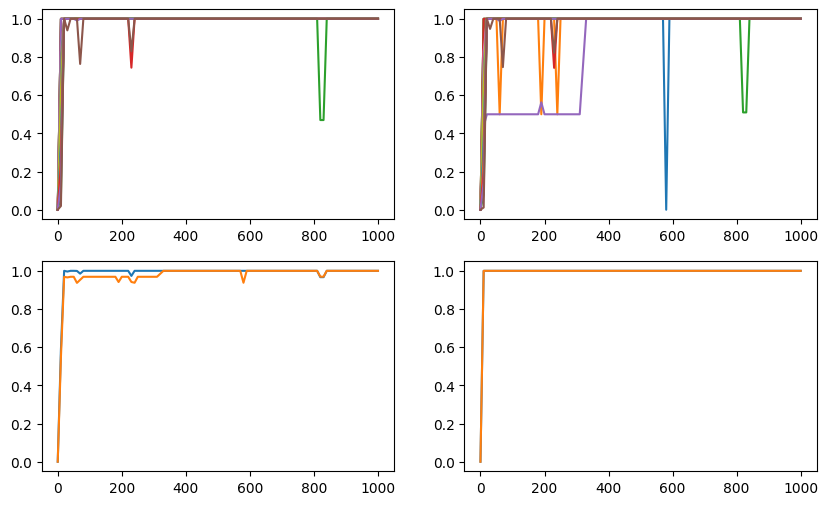

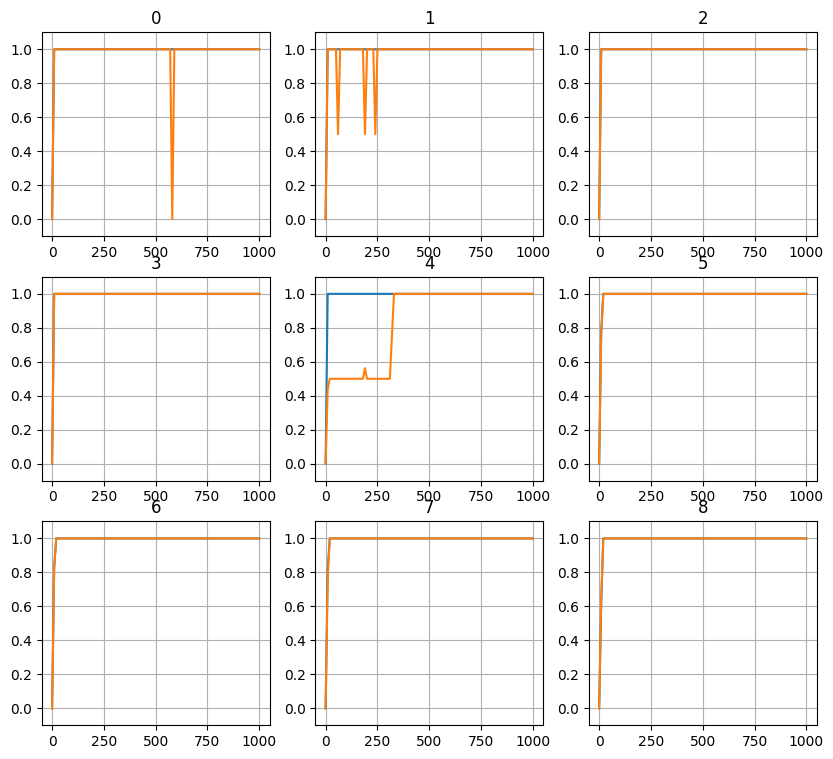

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].plot(timestamps, acc_by_len)
axes[0, 1].plot(timestamps, test_acc_by_len)
axes[1, 0].plot(timestamps, acc_by_len.mean(axis=1))
axes[1, 0].plot(timestamps, test_acc_by_len.mean(axis=1))
axes[1, 1].plot(timestamps, spe_acc[:, 2])
axes[1, 1].plot(timestamps, test_spe_acc[:, 2])
# axes[1, 1].set_xlim(0, 50)

nb_len = 9
fig, axes = plt.subplots(nb_len // 3 + (1 if nb_len % 3 else 0), 3, figsize=(10, 9))
for i in range(nb_len):
    axes[i // 3, i % 3].plot(timestamps, acc_by_len[:, i])
    axes[i // 3, i % 3].plot(timestamps, test_acc_by_len[:, i])
    axes[i // 3, i % 3].set_ylim(-.1, 1.1)
    axes[i // 3, i % 3].set_title(i)
    axes[i // 3, i % 3].grid()

## Check for meaning correctness

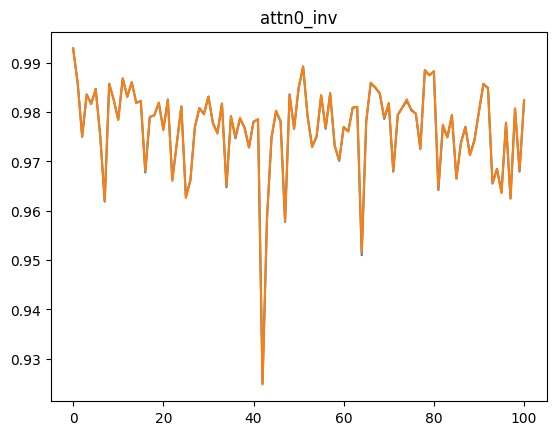

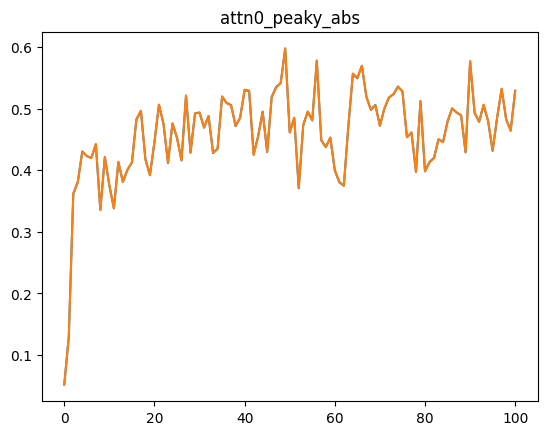

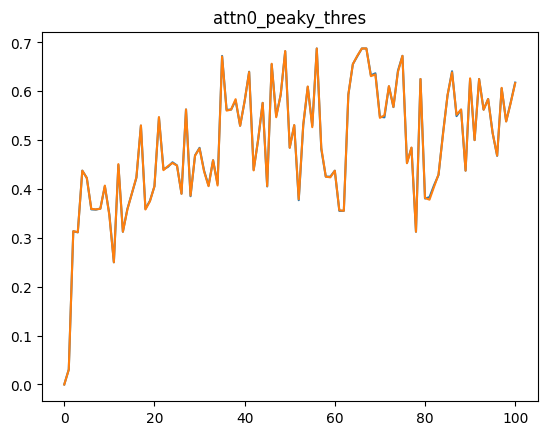

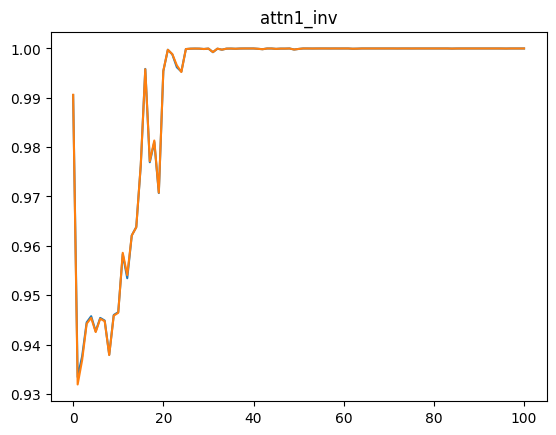

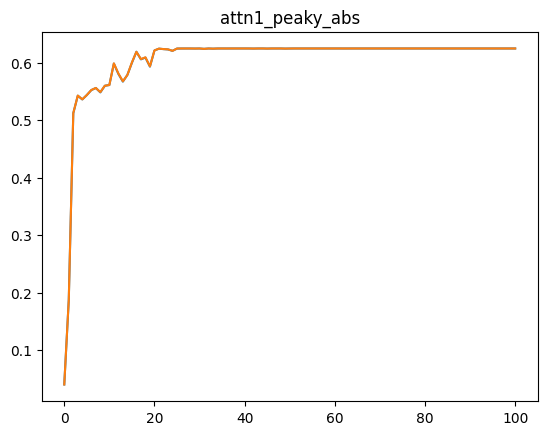

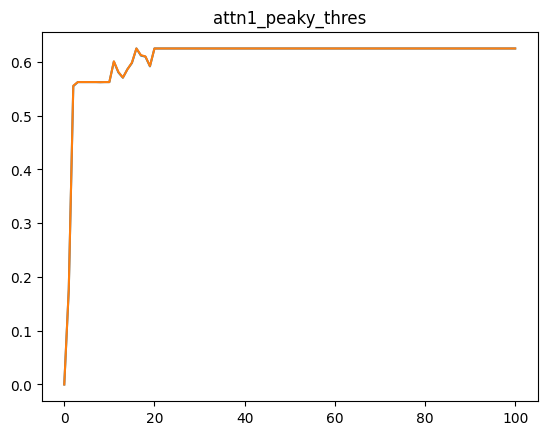

In [18]:
for eval in ['attn0_inv', 'attn0_peaky_abs', 'attn0_peaky_thres', 'attn1_inv', 'attn1_peaky_abs', 'attn1_peaky_thres']:
    ind = np.zeros(len(meaning), dtype=bool)
    for i, stri in enumerate(meaning):
        if stri.startswith(eval):
            ind[i] = True
    train_ind = np.hstack((np.zeros_like(ind), ind))
    train_tmp = evals[:, train_ind]
    test_ind = np.hstack((ind, np.zeros_like(ind)))
    test_tmp = evals[:, test_ind]
    fig, ax = plt.subplots()
    ax.plot(train_tmp[:, -1])
    ax.plot(test_tmp[:, -1])
    ax.set_title(eval)

## Looking at the model

In [19]:
token_emb = checkpoint['model_state_dict']['embeddings.token_emb.weight'].cpu()
pos_emb = checkpoint['model_state_dict']['embeddings.pos_emb.weight'].cpu()

In [22]:
lengths = list(np.arange(n_len) + 1)

if problem == 'binary-copy':
    testset = BinaryCopy()
elif problem == 'parity':
    testset = Parity()
testset.set_data(lengths, data_type="test")

In [23]:
config = TransformerConfig(
    vocab_size=torch.max(testset.data).item() + 1,
    emb_dim=emb_dim,
    pos_emb=True,
    seq_len=len(testset[0]),
    emb_dropout=0,
    n_head=n_head,
    n_layer=n_layer,
)

model = Transformer(config)
model.load_state_dict(checkpoint["model_state_dict"])
# model.to(device=device)
model.eval()

Transformer(
  (embeddings): Embedding(
    (token_emb): Embedding(5, 128)
    (pos_emb): Embedding(35, 128)
  )
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_mat): Linear(in_features=128, out_features=384, bias=False)
        (output): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=False)
        (fc2): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (output_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=128, out_features=5, bias=False)
)

In [24]:
sequence = testset.data
# sequence = sequence.to(device=device, dtype=torch.long)

with torch.no_grad():
    logits, attentions = model(sequence, verbose=True)

We can extract the attention scores that we would like to maximize.

In [25]:
seq = sequence[-1]
attn0 = attentions[0, -2, 0].cpu()
attn1 = attentions[1, -2, 0].cpu()

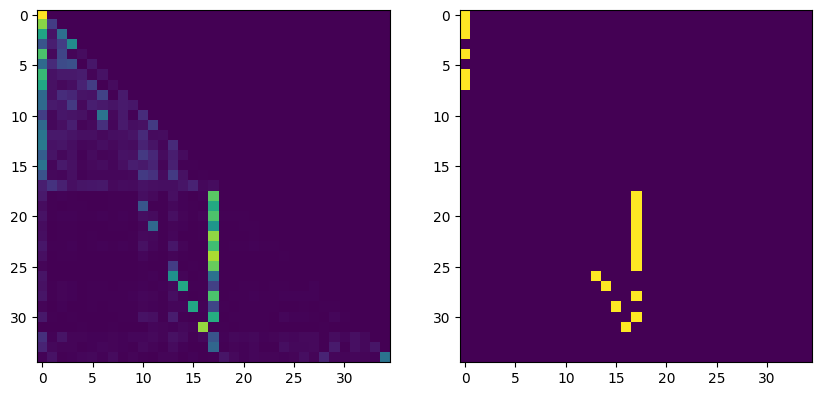

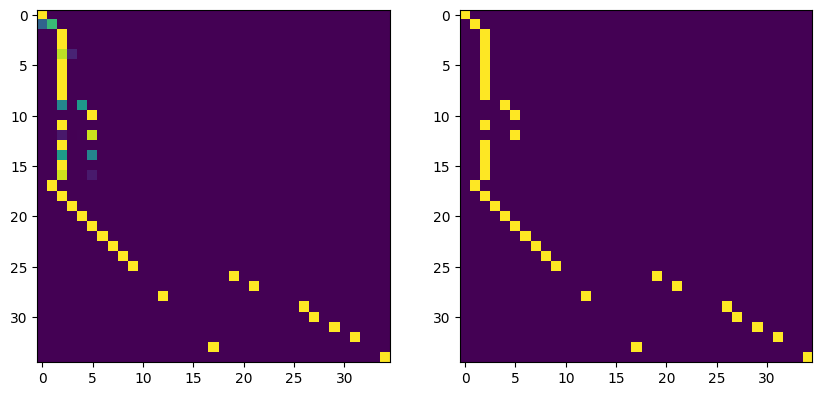

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn0)
axes[1].imshow(attn0 > .5)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn1)
axes[1].imshow(attn1 > .5)